In [2]:
from matplotlib import pyplot as plt
import numpy as np
import pandas as pd

import sys

sys.path.append('../')
from common_util import ProjectPaths,setup_plotting_format,setup_axis_default
paths = ProjectPaths()
sys.path.append(str(paths.STRUCTURAL_DATA))

from mech_prop_db import minimum_uniform_elongation
#ignore warnings and set preference for matplotlib styles
import warnings

warnings.filterwarnings("ignore")
setup_plotting_format()



#Constants for Unit Conversion
temperature = np.linspace(293.15,1300,100)
KSI_TO_MPA = 6.89476
NCM2_TO_MPA = 0.01
KGMM2_TO_MPA = 9.80665

#Read in various data sets and convert units

#ITER

iter_w_min_unif_elongation = minimum_uniform_elongation(temperature)
iter_w_min_unif_elongation = pd.DataFrame(iter_w_min_unif_elongation,index = temperature,columns = ['Min Unif Elongation [%]'])

#Mabouchi
mabuchi_wdf = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('mabuchi_w.csv'))
mabuchi_wL10df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('mabuchi_wl10.csv'))

#Nogami
nogami_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('nogami_data.csv'),index_col = 0)

#Haibany
habainy_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('habainy.csv'))

#Yin
yin_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('yin_data2020.csv')).iloc[8:]
for column in yin_df.columns:
    if column not in ['Materials']:
        yin_df[column].iloc[yin_df[column] == '�'] = np.nan
        yin_df[column] = yin_df[column].astype(float)

#Miyazawa
miyazawa_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('miyazawa_data2020.csv'))
for column in miyazawa_df.columns:
    if column not in ['Sample ID','Material type']:
        miyazawa_df[column].iloc[miyazawa_df[column] == '�'] = np.nan
        miyazawa_df[column] = miyazawa_df[column].astype(float)


ratcliff_df = pd.read_csv(paths.STRUCTURAL_DATA.joinpath('ratcliff/elongation_bounds.csv'),index_col= 0)


### Uniform Elongation

Uniform elongation is another important material property, which for our purposes indicates how "ductile" a material is. Informed by engineering design codes, we assume that a uniform elongation measured below 2% corresponds to a non-ductile material. Tungsten and it's alloys are famously brittle, which makes their use as structural materials dangerous as failure can occur suddenly and without warning.

The below scatter shows uniform elongation scatter plotted as a function of temperature for various tungsten alloys, produced in a variety of ways. Even more so then the ultimate tensile strength, there is a broad range of uniform elongation at each temperature across alloys.

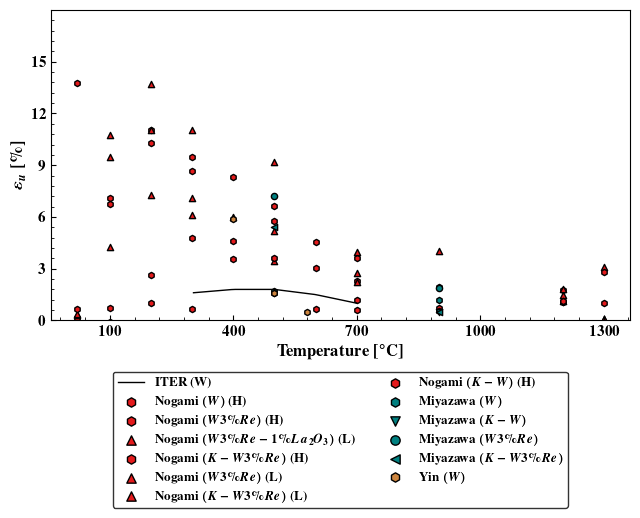

In [4]:
import pickle

MARKER_SIZE = 20
ALPHA = 1.0
fig,axes = plt.subplots(nrows =  2,figsize = (6.5,5.25),height_ratios = [1,0.3])
ax,legend_ax = axes
setup_axis_default(ax)

ax.set_xlabel(r'\textbf{Temperature} \textbf{[}$^\circ$\textbf{C]}',fontsize = 12)
ax.set_ylabel(r'$\varepsilon_u \ [\%]$',fontsize  = 12)

#ITER Data

ax.plot(temperature,iter_w_min_unif_elongation,linewidth = 1.,color = 'k',
        label = 'ITER ($\mathbf{W}$)')


#Nogami

alloys = {'UE [%] W Plate (H)':('Nogami $(W)$ (H)','h'),
          'UE [%] W3%Re Plate (H)':(r'Nogami  $(W3\%Re)$ (H)','h'),
          'UE [%] W3%Re-1%La2O3 Plate (L)':(r'Nogami $(W3\%Re-1\%La_2O_3)$ (L)','^'),
          'UE [%] K-W3%Re Plate (H)':(r'Nogami $(K-W3\%Re)$ (H)','h'),
          'UE [%] W3%Re Plate (L)':(r'Nogami $(W3\%Re)$ (L)','^'),
          'UE [%] K-W3%Re Plate (L)': (r'Nogami $(K-W3\%Re)$ (L)','^'),
          'UE [%] K-W Plate (H)': (r'Nogami $(K-W)$ (H)','h'),
}

colors = plt.get_cmap('Set1')(np.arange(0,1,1/8))
i = 0
for column,(label,marker) in alloys.items():
        ax.scatter(nogami_df.index,nogami_df[column],
                edgecolor = 'k', facecolor = colors[i], s = MARKER_SIZE,label = label,
                marker = marker,alpha = ALPHA)
#Miyazawa

unirrad = np.isnan(miyazawa_df['dose [dpa]'].to_numpy())

alloys = {'Pure W (SR)':('Miyazawa $(W)$','h'),
          'K-doped W (SR)':('Miyazawa $(K-W)$','v'),
          'W-3%Re (SR)':('Miyazawa $(W3\%Re)$','o'),
          'K-doped W-3%Re (SR)':('Miyazawa $(K-W3\%Re)$','<')}

ai = miyazawa_df['Material type']== 'Pure W (SR)'

for column,(label,marker) in alloys.items():
        ai = miyazawa_df['Material type']== column    
        alloy_index = np.all(np.concatenate([unirrad[:,None],
                                        ai.to_numpy()[:,None]],axis = 1),
                        axis = 1)
        
        ax.scatter(miyazawa_df['Test temperature [C]'].loc[alloy_index],miyazawa_df['UE [%]'].loc[alloy_index],edgecolor = 'k',
                facecolor = (0,128/255,128/255),label = label,
                marker = marker,alpha = ALPHA,s = MARKER_SIZE)

#Yin data
unirrad = yin_df['Dose (dpa)'] == 0.0
ax.scatter(yin_df['Test temperature (oC)'].loc[unirrad],yin_df['Uniform elongation(%)'].loc[unirrad],edgecolor = 'k',
        facecolor = (205/255,133/255,63/255),label = 'Yin  $(W)$',
        marker = 'h',alpha = ALPHA,s = MARKER_SIZE)



handles,labels = ax.get_legend_handles_labels()
legend = legend_ax.legend(handles = handles,
                          labels = [r'\textbf{' + label + '}' for label in labels],
                          loc = 'center',ncol = 2,fontsize = 9.5,markerscale = 1.5)  
legend_ax.axis('off')
ax.set_yticks(np.arange(0,18,3))
ax.set_xticks(np.arange(100,1400,300))
ax.set_ylim([0,18])

legend.get_frame().set_edgecolor('black')
legend.get_frame().set_linewidth(1.0)


fig.tight_layout(pad = 0.1)
fig.tight_layout()
with open(paths.SCRATCH.joinpath('ue_data_fig.pkl'),'wb') as f:
    pickle.dump((fig,axes),f)

fig.savefig('../thesis_images/ue_data.svg',bbox_inches = 'tight')


### The Effect of Material Production Route

The effect of material production route is highlighted here by the differences in uniform elongation $\varepsilon_u$, especially for the K-doped 3% Re alloy. This is especially critical as the difference between the highly deformed (H) and less deformed (L) materials mean the material is either above or below the brittle material limit of 2%. While the (L) material is more ductile, it's ultimate tensile stress is greater, as shown in the [uts_data_exploration.ipynb](uts_data_exploration.ipynb).

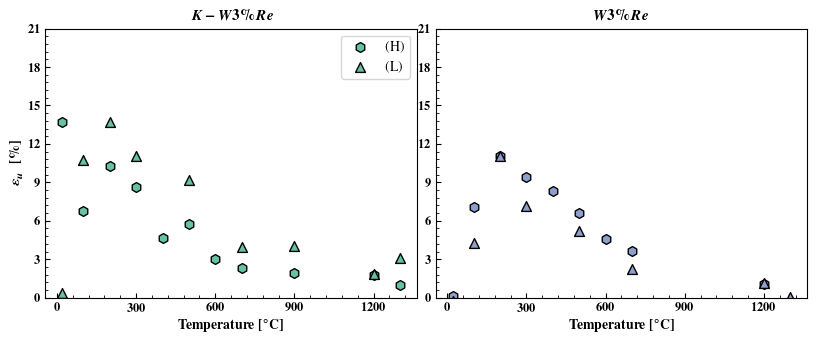

In [12]:
fig,axes = plt.subplots(ncols = 2,figsize = (8,3.25))
axes[0].set_ylabel(r'$\varepsilon_u$ \ \textbf{[\%]}',fontsize  = 10)
for ax in axes:
    ax.set_xlabel(r'\textbf{Temperature} \textbf{[}$^\circ$\textbf{C]}',fontsize = 10)
    ax.tick_params('both',labelsize = 9,direction = 'in',which = 'both')
    ax.set_xticks(np.arange(0,1300,300))
    ax.set_yticks(np.arange(0,24,3))
    ax.xaxis.set_minor_locator(AutoMinorLocator(5))
    ax.yaxis.set_minor_locator(AutoMinorLocator(5))
    ax.set_ylim([0,21])

alloys = [('UE [%] K-W3%Re Plate (H)','UE [%] K-W3%Re Plate (L)','$K-W3\%Re$',0.1),
           ('UE [%] W3%Re Plate (H)','UE [%] W3%Re Plate (L)','$W3\%Re$',0.3)]

for ax,(high,low,label,color) in zip(axes,alloys):
    ax.scatter(nogami_df.index,nogami_df[high],
                edgecolor = 'k', facecolor = plt.get_cmap('Set2')(color), s = 50,label = '(H)',
                marker = 'h',alpha = ALPHA)
    ax.scatter(nogami_df.index,nogami_df[low],
                edgecolor = 'k', facecolor = plt.get_cmap('Set2')(color), s = 50,label = '(L)',
                marker = '^',alpha = ALPHA)
    ax.set_title(label,fontsize = 11)

axes[0].legend(fontsize = 10)  
fig.tight_layout(pad = 0.1)